In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)

sns.set(style="whitegrid")

In [2]:
# Load data
df = pd.read_csv("../data/preprocessed_data.csv")

# Separate features and labels
X = df.drop("Revenue", axis=1)
y = df["Revenue"].astype(int)

# Stratified 80/20 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")
print(f"Positive rate in train: {y_train.mean():.4f} | test: {y_test.mean():.4f}")

Train samples: 9864 | Test samples: 2466
Positive rate in train: 0.1547 | test: 0.1549


In [3]:
# Logistic Regression + GridSearch

logreg_pipeline = Pipeline([
    ("model", LogisticRegression(class_weight="balanced", max_iter=1000, solver='liblinear'))
])

logreg_params = {
    "model__C": [0.01, 0.1, 1, 10]
}

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1",
    n_jobs=-1
)

grid_logreg.fit(X_train, y_train)
logreg_best = grid_logreg.best_estimator_
print("Best Logistic Regression Params:", grid_logreg.best_params_)

Best Logistic Regression Params: {'model__C': 0.1}


In [4]:
# SVM + GridSearch
svm_pipeline = Pipeline([
    ("model", SVC(class_weight="balanced", probability=True))
])

svm_params = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1",
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)
svm_best = grid_svm.best_estimator_
print("Best SVM Params:", grid_svm.best_params_)

Best SVM Params: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}


In [5]:
# Model evaluation function definition
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"----- {name} -----")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

----- Logistic Regression -----
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      2084
           1       0.52      0.75      0.61       382

    accuracy                           0.85      2466
   macro avg       0.73      0.81      0.76      2466
weighted avg       0.88      0.85      0.86      2466

F1 Score: 0.611764705882353
Precision: 0.5171790235081374
Recall: 0.7486910994764397
ROC AUC: 0.8959574820874074


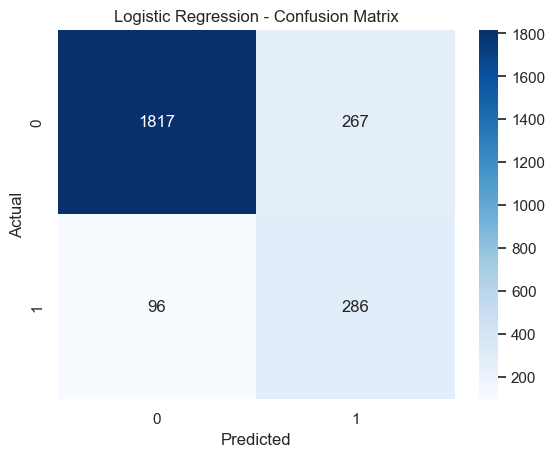

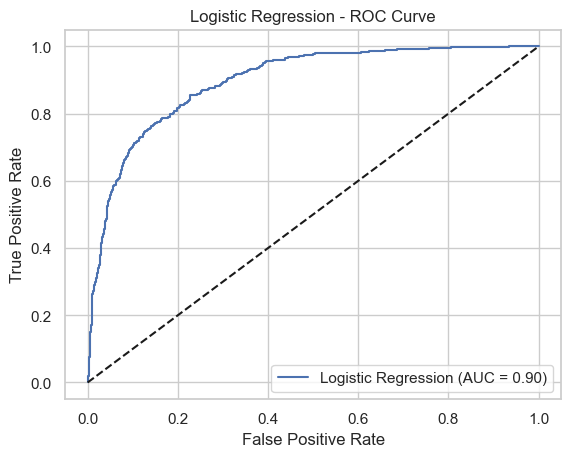

----- SVM -----
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      2084
           1       0.56      0.71      0.63       382

    accuracy                           0.87      2466
   macro avg       0.75      0.80      0.77      2466
weighted avg       0.88      0.87      0.87      2466

F1 Score: 0.6260069044879172
Precision: 0.5585215605749486
Recall: 0.7120418848167539
ROC AUC: 0.9014292389786053


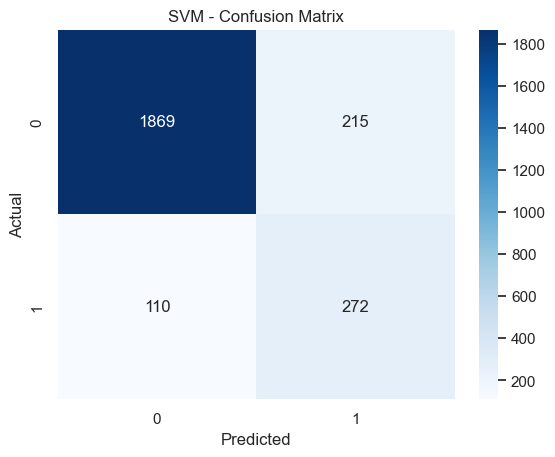

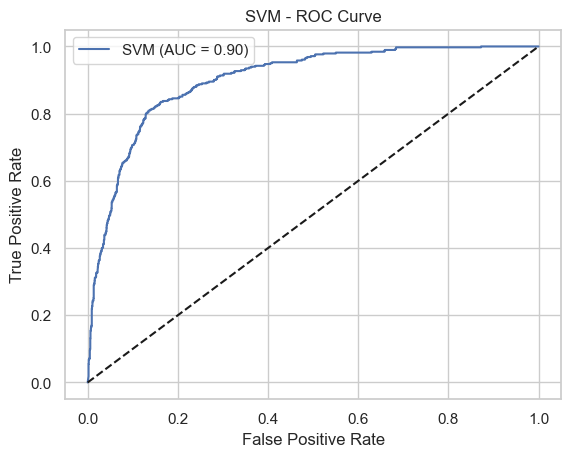

In [6]:
# Run evaluation
evaluate_model("Logistic Regression", logreg_best, X_test, y_test)
evaluate_model("SVM", svm_best, X_test, y_test)

In [7]:
import joblib

# Logistic Regression
joblib.dump(logreg_best, "../models/logreg.pkl")

# SVM
joblib.dump(svm_best, "../models/svm.pkl")

['../models/svm.pkl']

In [8]:
def evaluate_train_test_split(model, X_train, y_train, X_test, y_test, name="Model"):
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

    for label, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]
        print(f"🔹 {name} - {label} Set:")
        print(f"   F1 Score     : {f1_score(y, y_pred):.3f}")
        print(f"   Precision    : {precision_score(y, y_pred):.3f}")
        print(f"   Recall       : {recall_score(y, y_pred):.3f}")
        print(f"   ROC AUC      : {roc_auc_score(y, y_proba):.3f}\n")

In [9]:
evaluate_train_test_split(logreg_best, X_train, y_train, X_test, y_test, name="Logistic Regression")
evaluate_train_test_split(svm_best, X_train, y_train, X_test, y_test, name="SVM")

🔹 Logistic Regression - Train Set:
   F1 Score     : 0.634
   Precision    : 0.541
   Recall       : 0.765
   ROC AUC      : 0.910

🔹 Logistic Regression - Test Set:
   F1 Score     : 0.612
   Precision    : 0.517
   Recall       : 0.749
   ROC AUC      : 0.896
🔹 SVM - Train Set:
   F1 Score     : 0.659
   Precision    : 0.582
   Recall       : 0.758
   ROC AUC      : 0.914

🔹 SVM - Test Set:
   F1 Score     : 0.626
   Precision    : 0.559
   Recall       : 0.712
   ROC AUC      : 0.901
